In [211]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Data Load 및 간단한 EDA

In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
# housing.dtypes
housing.head(5)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing.info()
housing.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [11]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
housing["housing_median_age"].describe()

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64

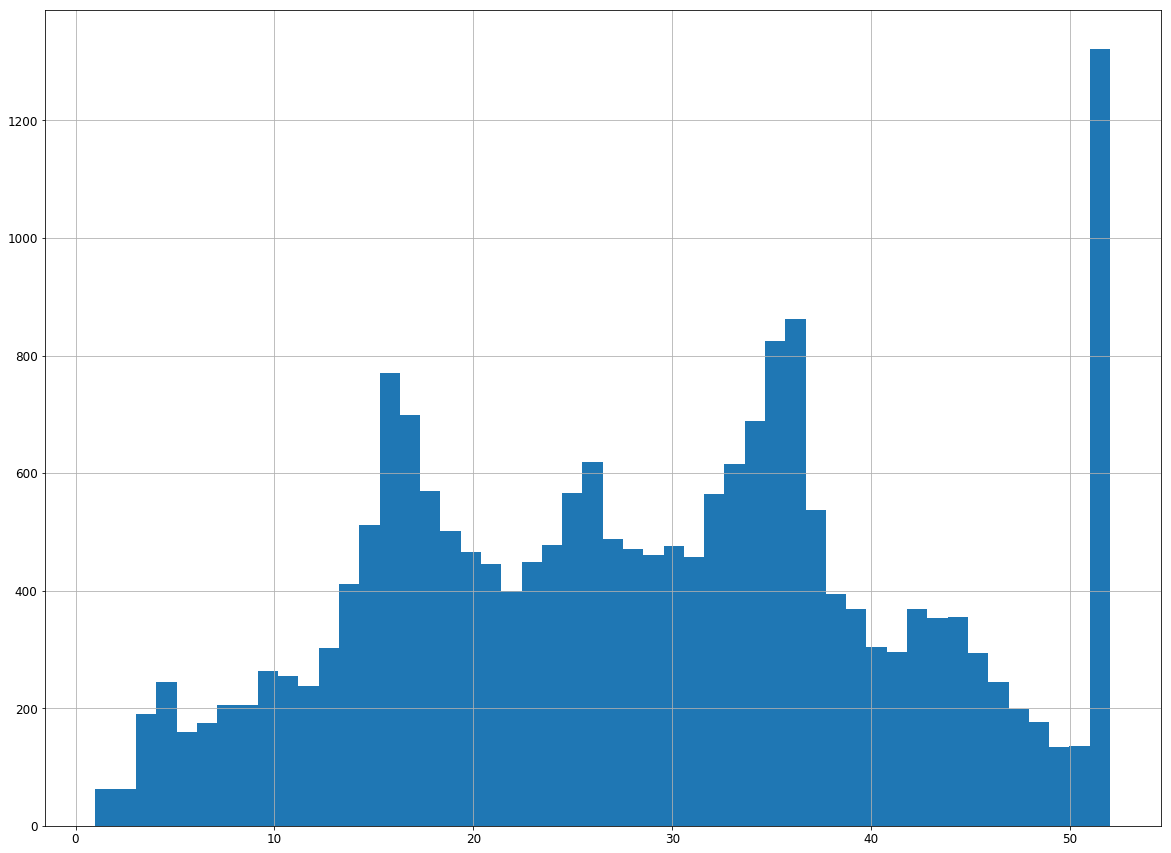

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
housing["housing_median_age"].hist(bins=50, figsize=(20,15))
# save_fig("attribute_histogram_plots")
plt.show()

# 1) train & test data set split

### random Seed를 이용한 split data

In [16]:
np.random.seed(1)

In [17]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [18]:
ind = np.random.permutation(len(housing))

In [30]:
test_ind = ind[:int(len(housing)*0.2)]
train_ind = ind[int(len(housing)*0.2):]

In [33]:
train_set = housing.iloc[train_ind]
len(train_set)
test_set = housing.iloc[test_ind]
len(test_set)

16512

### Hash key를 이용한 split data
#### 256 key 이용

In [36]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))

This version supports both Python 2 and Python 3, instead of just Python 3.
def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [50]:
hashlib.md5(np.int64(10)).digest()[-1]

139

In [51]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


In [100]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

### Scikit-Learn을 이용한 split data

In [95]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

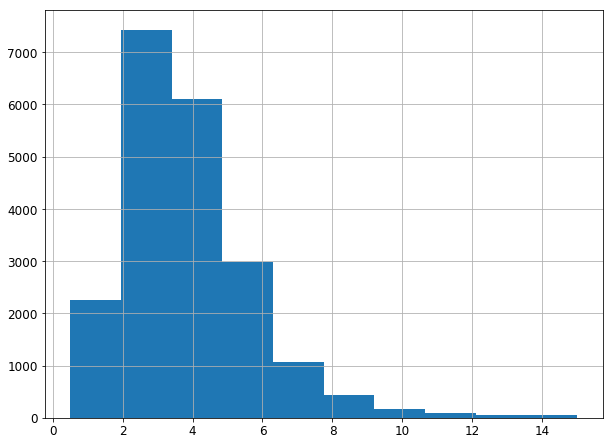

In [71]:
housing["median_income"].hist(figsize=(10,7.5), ax)
plt.show()

In [63]:
housing["median_income"].describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

### numeric value에 대한 PSA (Stratified shuffling)

In [102]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [80]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [98]:
(housing["income_cat"].value_counts(sort = False) / len(housing)).sort_index()

1.0    0.039826
2.0    0.318847
3.0    0.350581
4.0    0.176308
5.0    0.114438
Name: income_cat, dtype: float64

In [97]:
(strat_train_set["income_cat"].value_counts()/ len(housing)).sort_index()

1.0    0.031880
2.0    0.255087
3.0    0.280475
4.0    0.141037
5.0    0.091521
Name: income_cat, dtype: float64

In [104]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
(train_set["income_cat"].value_counts()/len(train_set)).sort_index()

In [111]:
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


In [112]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 2) EDA

### 1. Visualizatoin of map

In [114]:
housing_eda = strat_train_set.copy()

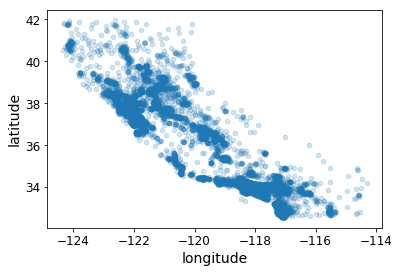

In [116]:
housing_eda.plot(kind = 'scatter', x = 'longitude', y= 'latitude', alpha = 0.2)

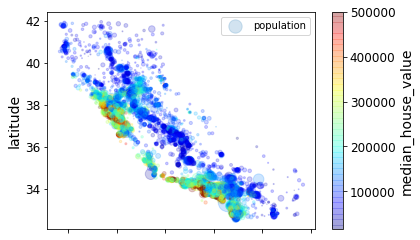

In [125]:
housing_eda.plot(kind = 'scatter', x = 'longitude', y= 'latitude', alpha = 0.2
                , s = housing_eda["population"]/100 # radius circle
                , label = "population"
                , c = "median_house_value" # color
                , cmap = plt.get_cmap("jet") # predefined color-map
                , colorbar = True)
plt.legend()

### 2. Correlation

In [130]:
corr_mat = housing_eda.corr()

In [135]:
corr_mat["median_house_value"].sort_values(ascending = True)

latitude             -0.142724
longitude            -0.047432
population           -0.026920
total_bedrooms        0.047689
households            0.064506
housing_median_age    0.114110
total_rooms           0.135097
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

[0, 16, 0, 550000]

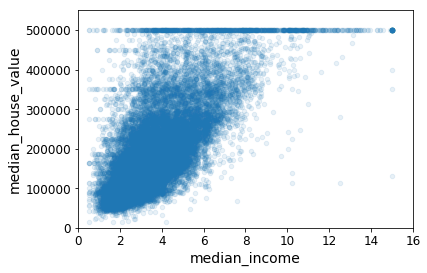

In [140]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ccd68d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119928cc0>]], dtype=object)

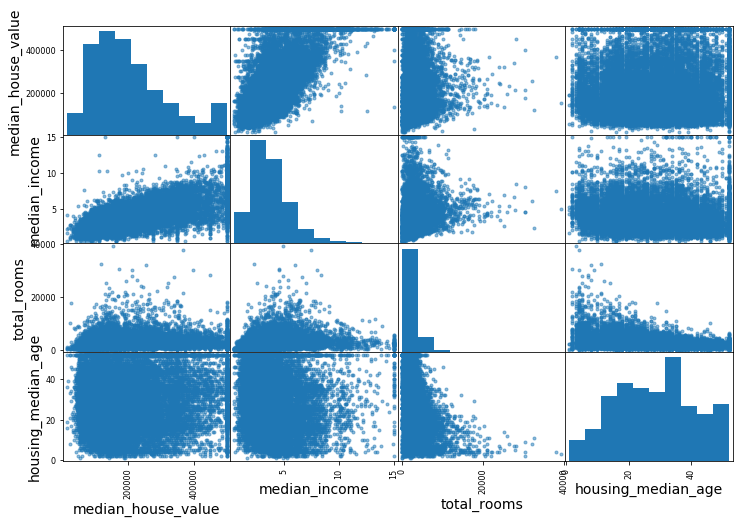

In [142]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

In [143]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [145]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

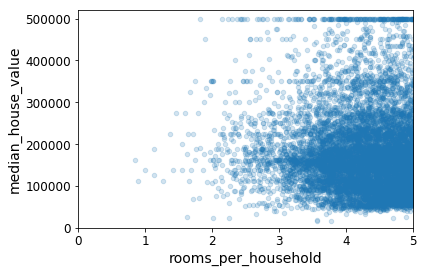

In [146]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

# Preparing the data for ML algorithms

In [158]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [149]:
housing.iloc[21:24]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
18086,-122.05,37.31,25.0,4111.0,538.0,1585.0,568.0,9.2298,<1H OCEAN
16718,-120.66,35.49,17.0,4422.0,945.0,2307.0,885.0,2.8285,<1H OCEAN
13600,-117.25,34.16,37.0,1709.0,278.0,744.0,274.0,3.7188,INLAND


In [153]:
housing.loc[21:24,]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
21,-122.27,37.85,42.0,1639.0,367.0,929.0,366.0,1.7135,NEAR BAY
3673,-118.39,34.22,40.0,712.0,149.0,533.0,155.0,3.6950,<1H OCEAN
17147,-122.19,37.44,39.0,4402.0,618.0,1616.0,631.0,8.9955,NEAR OCEAN
8564,-118.42,33.92,25.0,3521.0,852.0,1524.0,764.0,3.8086,<1H OCEAN
9629,-121.00,37.25,31.0,1923.0,341.0,806.0,349.0,3.1738,INLAND
10710,-117.70,33.60,26.0,1021.0,230.0,301.0,208.0,2.6250,<1H OCEAN
19051,-121.81,38.43,30.0,1674.0,297.0,756.0,292.0,3.9286,INLAND
10465,-117.76,33.48,38.0,3832.0,809.0,1332.0,636.0,5.0044,<1H OCEAN
7650,-118.27,33.84,24.0,6303.0,1277.0,3728.0,1252.0,3.9227,<1H OCEAN
20008,-119.06,36.15,20.0,1282.0,273.0,852.0,247.0,1.6354,INLAND


### deal with missing values
#### dropna, drop, fillna

In [172]:
# NA 찾기
pd.isnull(housing).sum() > 0

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
ocean_proximity       False
dtype: bool

In [163]:
# Summary...
housing_copy = housing.copy().iloc[21:24]
housing_copy.dropna(subset=["total_bedrooms"])    # option 1

housing_copy = housing.copy().iloc[21:24]
housing_copy.drop("total_bedrooms", axis=1)       # option 2

housing_copy = housing.copy().iloc[21:24]
median = housing_copy["total_bedrooms"].median()
housing_copy["total_bedrooms"].fillna(median, inplace=True) # option 3

### Estimator를 이용한 NA 처리
#### - fit(), transform(), fit_transform()
#### - predict(), score() : 예측시
#### - inspection : strategy, statistics_

In [165]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [168]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
ocean_proximity        object
dtype: object

In [170]:
housing_num = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [182]:
## 현재 NA는 total_bedrooms밖에 없지만, 추후 다른 데이터셋에서 na가 들어올 것을 대비해서 미리 계산
imputer.statistics_
# X = imputer.transform(housing_num)

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [181]:
housing_num.mean().values

array([ -119.57583394,    35.63957728,    28.65310078,  2622.7283188 ,
         534.97389018,  1419.7908188 ,   497.06038033,     3.87558937])

In [187]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

In [189]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [190]:
imputer.strategy

'median'

### deal with categorical variable

In [194]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [196]:
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)

In [200]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [201]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [209]:
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1)) # SciPy Array
# http://kascia.tistory.com/5 (reshape 관련)

In [202]:
housing_cat_encoded.reshape(-1,1)

array([[0],
       [0],
       [4],
       ..., 
       [1],
       [0],
       [3]])

In [216]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [207]:
housing_cat_encoded.info()

AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [218]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot # NumPy Array

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])